In [1]:
# ==============================================================================
# 1. 라이브러리 및 설정
# ==============================================================================

import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ExifTags
import numpy as np
import json
import mlflow
from transformers import ViTImageProcessor, AutoModelForImageClassification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# MLflow 트래킹 서버 URI 설정
mlflow.set_tracking_uri("http://0.0.0.0:5000")
# MLflow 실험 이름 설정 (학습 시 사용한 실험 이름과 일치해야 함)
mlflow.set_experiment("FER Fine-tuning with Soft Labels")

# 백본 모델 클래스 순서
backbone_classes = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

/workspace/miniconda3/envs/mlflow_env/lib/python3.11/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
# ==============================================================================
# 2. 데이터셋 클래스 및 보조 함수 (독립적인 실행을 위해 포함)
# ==============================================================================

# EmotionDataset 클래스 (바운딩 박스 평균 크롭 로직 포함)
class EmotionDataset(Dataset):
    def __init__(self, csv_file, processor, phase, backbone_classes):
        self.df = pd.read_csv(csv_file)
        self.df = self.df[self.df['phase'] == phase].reset_index(drop=True)
        self.processor = processor
        self.backbone_classes = backbone_classes
        
        for col in ['annot_A', 'annot_B', 'annot_C']:
            def safe_json_loads(x):
                if pd.isna(x) or not isinstance(x, str) or not x.strip():
                    return np.nan
                try:
                    return json.loads(x.replace("'", '"'))
                except json.JSONDecodeError:
                    return np.nan
            self.df[col] = self.df[col].apply(safe_json_loads)
            
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['img_path']
        
        try:
            image = Image.open(image_path)
            image = self.correct_image_orientation(image)
            image = image.convert("RGB")
        except (IOError, FileNotFoundError) as e:
            # 파일이 없거나 손상된 경우 건너뛰기
            print(f"오류: {e}. 샘플 {idx}를 건너뜁니다.")
            return self.__getitem__((idx + 1) % len(self))
            
        soft_label_vector = torch.tensor(
            [row[f"soft_{cls}"] for cls in self.backbone_classes],
            dtype=torch.float
        )
        
        minX_coords, minY_coords, maxX_coords, maxY_coords = [], [], [], []
        for annotator in ['annot_A', 'annot_B', 'annot_C']:
            if pd.notna(row[annotator]) and 'boxes' in row[annotator]:
                boxes = row[annotator]['boxes']
                minX_coords.append(boxes['minX'])
                minY_coords.append(boxes['minY'])
                maxX_coords.append(boxes['maxX'])
                maxY_coords.append(boxes['maxY'])
        
        if minX_coords:
            avg_minX, avg_minY = np.mean(minX_coords), np.mean(minY_coords)
            avg_maxX, avg_maxY = np.mean(maxX_coords), np.mean(maxY_coords)
            cropped_image = image.crop((int(avg_minX), int(avg_minY), int(avg_maxX), int(avg_maxY)))
        else:
            cropped_image = image
        
        inputs = self.processor(images=cropped_image, return_tensors="pt")
        inputs['pixel_values'] = inputs['pixel_values'].squeeze()

        return inputs['pixel_values'], soft_label_vector
    
    def correct_image_orientation(self, img):
        try:
            exif = img._getexif()
            if exif is not None:
                for tag, value in exif.items():
                    if ExifTags.TAGS.get(tag, None) == 'Orientation':
                        if value == 1: pass
                        elif value == 2: img = img.transpose(Image.FLIP_LEFT_RIGHT)
                        elif value == 3: img = img.rotate(180, expand=True)
                        elif value == 4: img = img.transpose(Image.FLIP_TOP_BOTTOM)
                        elif value == 5: img = img.transpose(Image.FLIP_LEFT_RIGHT).rotate(-90, expand=True)
                        elif value == 6: img = img.rotate(-90, expand=True)
                        elif value == 7: img = img.transpose(Image.FLIP_LEFT_RIGHT).rotate(90, expand=True)
                        elif value == 8: img = img.rotate(90, expand=True)
        except Exception: pass
        return img

In [3]:
# ==============================================================================
# 3. 모델 로드 및 테스트 세트 준비
# ==============================================================================

# MLflow run_id를 지정합니다. (08_finetuning.py 실행 후 MLflow UI에서 확인)
# 예: run_id = "c88cb1374eed41dc9d164a91a5f4e956"
# 아래 코드에서 run_id를 적절히 수정해 주세요.
run_id = "c88cb1374eed41dc9d164a91a5f4e956" 

# MLflow에서 파인튜닝된 모델 로드
try:
    model_uri = f"runs:/{run_id}/emotion_fine_tuned_model"
    model = mlflow.pytorch.load_model(model_uri)
    print(f"MLflow에서 run_id: {run_id}의 모델을 성공적으로 로드했습니다.")
except Exception as e:
    print(f"모델 로드 실패: {e}")
    # 예외 발생 시, 로컬에서 모델을 로드하는 대체 코드를 작성할 수 있습니다.
    model_name = "HardlyHumans/Facial-expression-detection"
    model = AutoModelForImageClassification.from_pretrained(model_name)
    print("로컬에서 백본 모델을 로드했습니다.")
    
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

processor = ViTImageProcessor.from_pretrained("HardlyHumans/Facial-expression-detection", use_fast=True)
csv_path = '06_softlabel_dataset_resplit.csv'

# 'test' 세트를 사용하여 데이터로더 생성
test_dataset = EmotionDataset(csv_path, processor, 'test', backbone_classes)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

MLflow에서 run_id: c88cb1374eed41dc9d164a91a5f4e956의 모델을 성공적으로 로드했습니다.


In [5]:
# ==============================================================================
# 4. 테스트 세트 평가 및 지표 계산
# ==============================================================================

# 소프트 라벨 기반 평가를 위한 손실 함수
loss_fn_eval = nn.KLDivLoss(reduction="batchmean") 
softmax_layer_eval = nn.LogSoftmax(dim=1)

y_true_soft = []
y_pred_soft = []
total_kl_loss = 0

with torch.no_grad():
    for images, soft_labels in tqdm(test_loader, desc="테스트 세트 평가"):
        images = images.to(device)
        soft_labels = soft_labels.to(device)
        
        outputs = model(pixel_values=images).logits
        
        # 소프트 라벨 기반 손실 계산
        loss = loss_fn_eval(softmax_layer_eval(outputs), soft_labels)
        total_kl_loss += loss.item()
        
        # 하드 라벨 기반 지표 계산을 위해 예측/실제값 저장
        y_true_soft.extend(soft_labels.cpu().numpy())
        y_pred_soft.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# 평균 KL-Divergence Loss 계산
avg_kl_loss = total_kl_loss / len(test_loader)

# ==============================================================================
# 4-a. 하드 라벨 변환 및 전통적인 지표 계산
# ==============================================================================

# 소프트 라벨을 하드 라벨로 변환 (argmax를 사용)
y_true_hard = np.argmax(y_true_soft, axis=1)
y_pred_hard = np.argmax(y_pred_soft, axis=1)

# 지표 계산
accuracy = accuracy_score(y_true_hard, y_pred_hard)
f1_macro = f1_score(y_true_hard, y_pred_hard, average='macro', zero_division=0)
precision_macro = precision_score(y_true_hard, y_pred_hard, average='macro', zero_division=0)
recall_macro = recall_score(y_true_hard, y_pred_hard, average='macro', zero_division=0)

print("\n==== 테스트 세트 성능 지표 ====")
print(f"평균 KL-Divergence Loss: {avg_kl_loss:.4f} (낮을수록 좋음)")
print(f"정확도: {accuracy:.4f}")
print(f"F1-점수 (Macro): {f1_macro:.4f}")
print(f"정밀도 (Macro): {precision_macro:.4f}")
print(f"재현율 (Macro): {recall_macro:.4f}")

테스트 세트 평가:   0%|          | 0/53 [00:00<?, ?it/s]


==== 테스트 세트 성능 지표 ====
평균 KL-Divergence Loss: 0.5322 (낮을수록 좋음)
정확도: 0.6930
F1-점수 (Macro): 0.5136
정밀도 (Macro): 0.5556
재현율 (Macro): 0.5062


/tmp/ipykernel_323629/1072463213.py:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


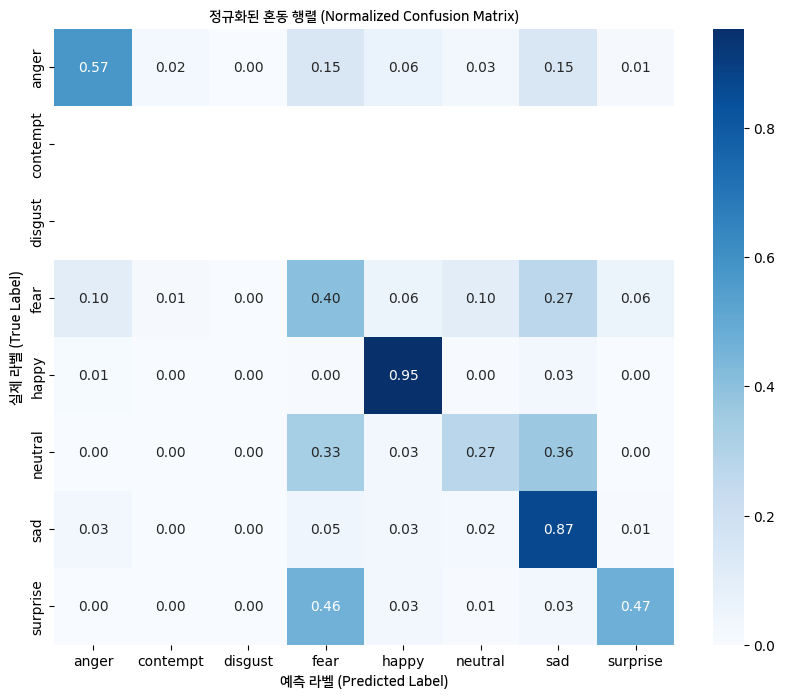

In [13]:
# ==============================================================================
# 5. 혼동 행렬 시각화
# ==============================================================================
# 폰트 설정 (한글용)
import matplotlib.font_manager as fm
font_path = "/usr/share/fonts/truetype/nanum/NanumSquareB.ttf" # 실제 파일경로
font_prop = fm.FontProperties(fname=font_path)

# confusion_matrix에 모든 클래스 라벨을 명시하여 (8x8) 행렬을 생성하도록 수정
cm = confusion_matrix(y_true_hard, y_pred_hard, labels=range(len(backbone_classes)))

# 정규화된 혼동 행렬 계산
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# NaN 값을 'X'로 표시하기 위한 어노테이션 배열 생성
text_annotations = np.empty_like(cm_normalized, dtype=object)
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        if np.isnan(cm_normalized[i, j]):
            text_annotations[i, j] = 'X'
        else:
            text_annotations[i, j] = f"{cm_normalized[i, j]:.2f}"

plt.figure(figsize=(10, 8))
# fmt=""로 설정하여 seaborn이 자동으로 숫자 형식을 지정하지 않도록 함
# annot에 직접 어노테이션 배열을 전달
sns.heatmap(cm_normalized, annot=text_annotations, fmt="", cmap='Blues', 
            xticklabels=backbone_classes, yticklabels=backbone_classes)
plt.title('정규화된 혼동 행렬 (Normalized Confusion Matrix)', fontproperties=font_prop)
plt.ylabel('실제 라벨 (True Label)', fontproperties=font_prop)
plt.xlabel('예측 라벨 (Predicted Label)', fontproperties=font_prop)
plt.show()

In [ ]:
# ==============================================================================
# 6. MLflow에 최종 결과 로깅 (선택 사항)
# ==============================================================================
# 이전에 학습했던 run에 추가로 로깅하여 최종 결과를 한 곳에서 관리
with mlflow.start_run(run_id=run_id):
    mlflow.log_metric("test_kl_loss", avg_kl_loss)
    mlflow.log_metric("test_accuracy", accuracy)
    mlflow.log_metric("test_f1_macro", f1_macro)
    
    # 혼동 행렬 이미지를 아티팩트로 저장
    plt.savefig("09_confusion_matrix.png")
    mlflow.log_artifact("09_confusion_matrix.png")
    print(f"최종 테스트 결과 및 혼동 행렬이 MLflow run: {run_id}에 저장되었습니다.")

최종 테스트 결과 및 혼동 행렬이 MLflow run: c88cb1374eed41dc9d164a91a5f4e956에 저장되었습니다.
🏃 View run fine_tuning_run_1 at: http://0.0.0.0:5000/#/experiments/1/runs/c88cb1374eed41dc9d164a91a5f4e956
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/1


<Figure size 640x480 with 0 Axes>

: 